*Portions of the Python code, including data cleaning, data preparation, and segments of the regression analysis, have been adapted from the Stata code provided in Kaboski and Townsend's paper:*

Kaboski, Joseph P., and Robert M. Townsend. "The Impact of Credit on Village Economies." *American Economic Journal: Applied Economics* 4, no. 2 (2012): 98–133. https://doi.org/10.1257/app.4.2.98.

## Data Cleaning

In [39]:
import pandas as pd
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Load the Stata data file
df = pd.read_stata('AnnualData_ShortSample.dta')

# Sort the DataFrame by 'case_id'
df.sort_values('case_id', inplace=True)

# Create total investment variable 'tinv'
df['tinv'] = df[['hinv', 'finv', 'pinv', 'binv', 'bafdn', 'sinv', 'safdn', 'lvcn', 'lvnn', 'lvdep']].sum(axis=1)

# Create total wages paid 'twage'
df['twage'] = df['frmwage'] + df['shrwage'] + df['buswage']

# Drop 'frmwage', 'shrwage', and 'buswage' columns
df.drop(columns=['frmwage', 'shrwage', 'buswage'], inplace=True)

# Create 'farm' variable based on 'och' values
df['farm'] = ((df['och'] > -5) & (df['och'] <= 15)).astype(int)

# Create total business investment variable 'tbinv'
df['tbinv'] = df[['pinv', 'binv', 'bafdn', 'sinv', 'safdn']].sum(axis=1)

# Create age squared 'age2h'
df['age2h'] = df['ageh'] ** 2

# Create lands squared 'gassd2'
df['gassd2'] = df['gassd'] ** 2

# Create log of assets 'lgassd'
df['lgassd'] = np.log(df['gassd'])

# Create dlog assets 'dlgassd1' (log difference of gassd)
df['dlgassd1'] = df.groupby('case_id')['gassd'].transform(lambda x: np.log(x.shift(-1) / x))

# Create dnetinc (log difference of netinc)
df['dnetinc'] = df.groupby('case_id')['netinc'].transform(lambda x: np.log(x.shift(-1) / x))

# Create the log of the number of households in the village 'invHH'
df['invHH'] = 1 / df['vHH']

# Replace 'invHH' for year == 1 with the value from the next year (shifted)
df.loc[df['year'] == 1, 'invHH'] = df.groupby('case_id')['invHH'].transform(lambda x: x.shift(-1))

# Create log of the number of households in the village for the previous year 'invHHl'
df['invHHl'] = df.groupby('case_id')['vHH'].transform(lambda x: 1 / x.shift(1))

# Create 'vfstl' which is the value of 'vfst' from the previous year
df['vfstl'] = df.groupby('case_id')['vfst'].transform(lambda x: x.shift(1))

# Create 'bsnew' by summing 'bnew' and 'snew'
df['bsnew'] = df['bnew'] + df['snew']

# Specify the list of columns to keep
columns_to_keep = [
    'case_id', 'year', 'frmpro', 'buspro', 'wageinc', 'riceinc', 'cropinc', 'liveinc', 
    'educ', 'invHHl', 'vfstl', 'invHH', 'changwat', 'amphoe', 'tambon', 'village', 
    'dnetinc', 'dlgassd1', 'farm', 'netinc', 'bsnew', 'tc', 'educ', 'grain', 'milk', 
    'meat', 'alch1', 'alch2', 'fuel', 'tobac', 'cerem', 'houserep', 'vehicrep', 
    'clothes', 'mealaway', 'ageh', 'madult', 'fadult', 'kids', 'maleh', 'finv', 
    'tbinv', 'hinv', 'frtexp', 'netinc', 'lac', 'newst', 'vfst', 'infst', 'baacst', 
    'cbst', 'const', 'edust', 'agst', 'hhast', 'busst', 'frtst', 'age2h', 'educh', 
    'gassd', 'gassd2', 'lgassd', 'rst', 'defcr', 'twage'
]

# Keep only the specified columns
df = df[columns_to_keep]

# Create 'villageyear' by dividing 'case_id' by 1000 and converting to an integer
df['villageyear'] = (df['case_id'] // 1000).astype(int)

# Replace 'vfst' by dividing by 10000
df['vfst'] = df['vfst'] / 10000

# Replace 'vfstl' by dividing by 10000
df['vfstl'] = df['vfstl'] / 10000

# Sort the DataFrame by 'case_id' and 'year'
df = df.sort_values(by=['case_id', 'year'])

# Create 'invHHim' which is 'invHH' where year is 6
df['invHHim'] = np.where(df['year'] == 6, df['invHH'], np.nan)

# Create 'invHHi' as the mean of 'invHHim' within each 'case_id' group
df['invHHi'] = df.groupby('case_id')['invHHim'].transform('mean')

# Create 'vHHi' as the inverse of 'invHHi'
df['vHHi'] = 1 / df['invHHi']

# Drop rows where 'vHHi' is greater than 250 or less than 50
df = df[(df['vHHi'] <= 250) & (df['vHHi'] >= 50)]

# Create 'invHHpvf' which is 'invHHi' multiplied by a boolean indicating if 'year' is greater than 5
df['invHHpvf'] = df['invHHi'] * (df['year'] > 5)

# Create 'invHHtvf1' which is 'invHHi' if 'year' equals 6
df['invHHtvf1'] = df['invHHi'] * (df['year'] == 6)

# Create 'invHHtvf2' which is 'invHHi' if 'year' equals 7
df['invHHtvf2'] = df['invHHi'] * (df['year'] == 7)

# Create 'vfstf' by multiplying 'vfst' with a condition where 'maleh' equals 0
df['vfstf'] = df['vfst'] * (df['maleh'] == 0)

# Create 'invHHtvf1f' by multiplying 'invHHtvf1' with a condition where 'maleh' equals 0
df['invHHtvf1f'] = df['invHHtvf1'] * (df['maleh'] == 0)

# Create 'invHHtvf2f' by multiplying 'invHHtvf2' with a condition where 'maleh' equals 0
df['invHHtvf2f'] = df['invHHtvf2'] * (df['maleh'] == 0)

# Create 'vfstlf' by multiplying 'vfstl' with a condition where 'maleh' equals 0
df['vfstlf'] = df['vfstl'] * (df['maleh'] == 0)

# Create a new column 'caseid' as a copy of 'case_id', ensuring it's of type float (equivalent to 'double' in Stata)
df['caseid'] = df['case_id'].astype(float)

# Drop the 'case_id' column
df.drop(columns=['case_id'], inplace=True)

# Create a binary column 'tbinvp' which is True if 'tbinv' is greater than 0
df['tbinvp'] = df['tbinv'] > 0

# Create a binary column 'finvp' which is True if 'finv' is greater than 0
df['finvp'] = df['finv'] > 0

# Create a binary column 'defcrp' which is True if 'defcr' is greater than 0
df['defcrp'] = df['defcr'] > 0

# Keep rows where 'year' is less than 8
df = df[df['year'] < 8]

## Summary Statistics

### General Summary

In [40]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Step 1: Create a mapping for more understandable variable names
variable_names = {
    'newst': "New Short-Term Credit",
    'vfst_post_program': "Village Fund Credit (Divided by 10,000)",
    'ageh': "Age of Household's Head",
    'educh': "Years of Education of Household's Head",
    'farm': "Farming Dummy for Household Head’s Primary Occupation"
}

# Step 2: Create 'vfst_post_program' and 'vfst_pre_program' variables
df['vfst_post_program'] = df['vfst'].where(df['year'].isin([6, 7]), other=None)

# Step 3: Group by 'caseid' and calculate the mean for the specified variables, including the new ones
collapsed_df = df.groupby('caseid')[['newst', 'vfst_post_program', 'ageh', 'educh', 'farm']].mean()

# Step 4: Rename the columns for better readability
collapsed_df.rename(columns=variable_names, inplace=True)

# Step 5: Get the summary statistics for the collapsed data
summary_stats_interest = collapsed_df.describe()

# Step 6: Calculate cross-sectional standard deviation
cross_sectional_std = collapsed_df.std()

# Step 7: Transpose the table to make variables the rows and ensure correct order
summary_stats_transposed = summary_stats_interest.T.reindex([
    "New Short-Term Credit", 
    "Village Fund Credit (Divided by 10,000)",  
    "Age of Household's Head", 
    "Years of Education of Household's Head", 
    "Farming Dummy for Household Head’s Primary Occupation"
])

# Step 8: Add cross-sectional standard deviation to the transposed table
summary_stats_transposed['cross-sectional std'] = cross_sectional_std.reindex([
    "New Short-Term Credit", 
    "Village Fund Credit (Divided by 10,000)",  
    "Age of Household's Head", 
    "Years of Education of Household's Head", 
    "Farming Dummy for Household Head’s Primary Occupation"
])

# Update column titles for better readability
summary_stats_transposed.rename(columns={
    'mean': 'Mean',
    'std': 'Standard Deviation',
    'cross-sectional std': 'Cross-Sectional Standard Deviation',
    'count': 'Count',
    'min': 'Min',
    'max': 'Max'
    
}, inplace=True)

# Set the display format for cleaner number formatting (optional)
pd.set_option('display.float_format', '{:.2f}'.format)

# Step 8: Add a comment in the table caption
styled_table = summary_stats_transposed.style.set_caption(
    "Summary Statistics with Cross-Sectional Standard Deviation\n(Note: Village Fund Credit is divided by 10,000)"
).format("{:.2f}")  # Ensures consistent 2 decimal formatting

# Display the styled table
styled_table

,Count,Mean,Standard Deviation,Min,25%,50%,75%,Max,Cross-Sectional Standard Deviation
New Short-Term Credit,725.00,21831.07,35763.35,0.00,3571.43,10857.14,28321.43,528285.71,35763.35
"Village Fund Credit (Divided by 10,000)",725.00,0.93,0.86,0.00,0.00,1.00,1.65,5.00,0.86
Age of Household's Head,725.00,53.86,12.97,26.00,43.00,52.57,63.57,90.00,12.97
Years of Education of Household's Head,722.00,6.12,3.00,0.00,6.43,6.57,6.57,16.00,3.00
Farming Dummy for Household Head’s Primary Occupation,725.00,0.64,0.37,0.00,0.29,0.71,1.00,1.00,0.37


### Age of Household's Head

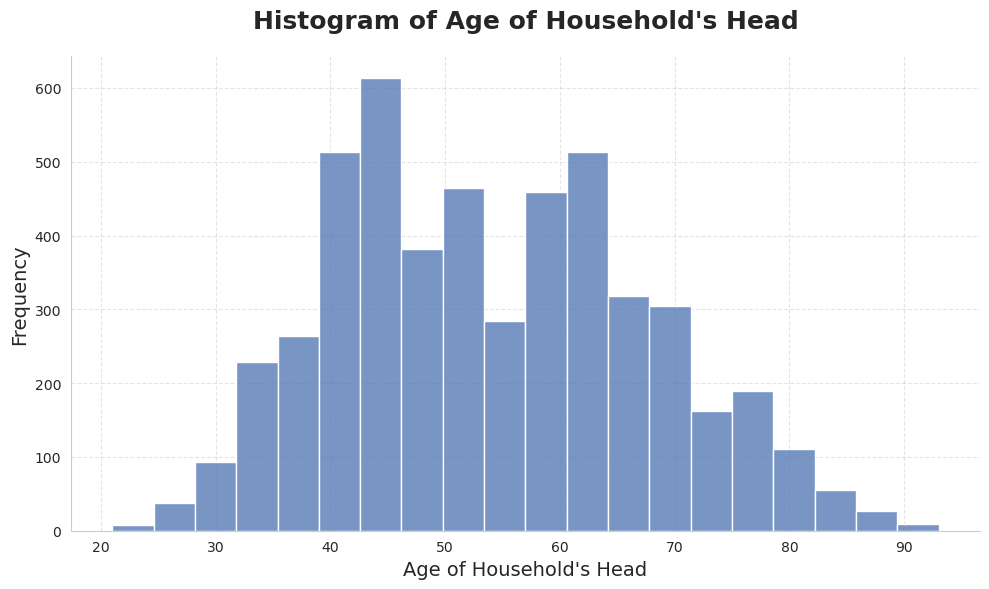

In [41]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Extract the relevant 'ageh' column (Age of Household Head)
ageh_data = df['ageh'].dropna()

# Plot the histogram of age
plt.figure(figsize=(10, 6))

# Plot histogram with softer color and edge
sns.histplot(ageh_data, bins=20, kde=False, color='#4c72b0', edgecolor='white')

# Customize the plot with a cleaner look
plt.title("Histogram of Age of Household's Head", fontsize=18, weight='bold', pad=20)
plt.xlabel("Age of Household's Head", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove the top and right spines for a cleaner look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

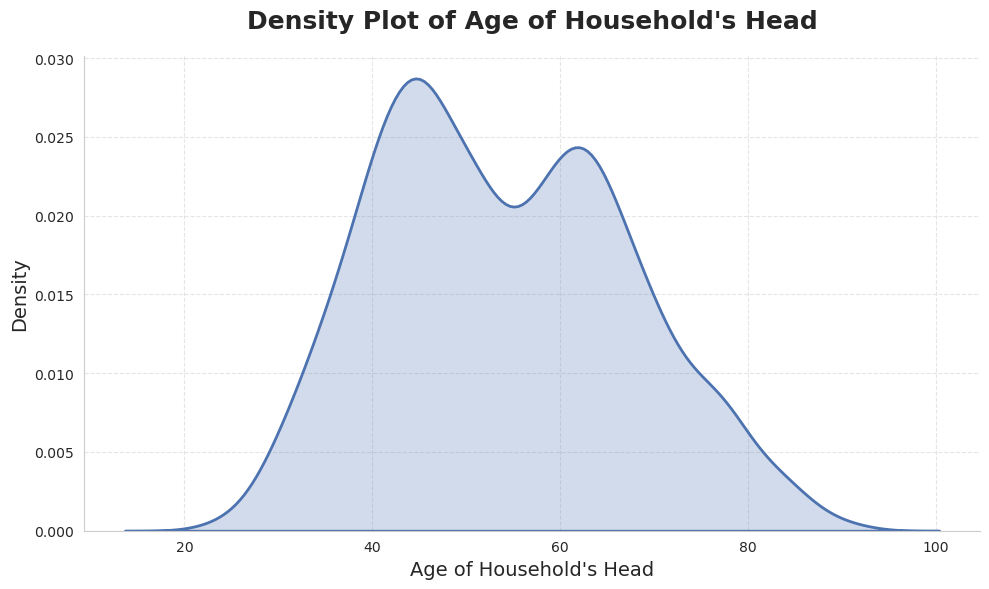

In [42]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Create a density plot for 'ageh'
plt.figure(figsize=(10, 6))

# Plot the density with a modern blue-gray color and shading
sns.kdeplot(df['ageh'].dropna(), shade=True, color='#4c72b0', lw=2)

# Add labels and title with a clean look
plt.title("Density Plot of Age of Household's Head", fontsize=18, weight='bold', pad=20)
plt.xlabel("Age of Household's Head", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Show the plot
plt.show()

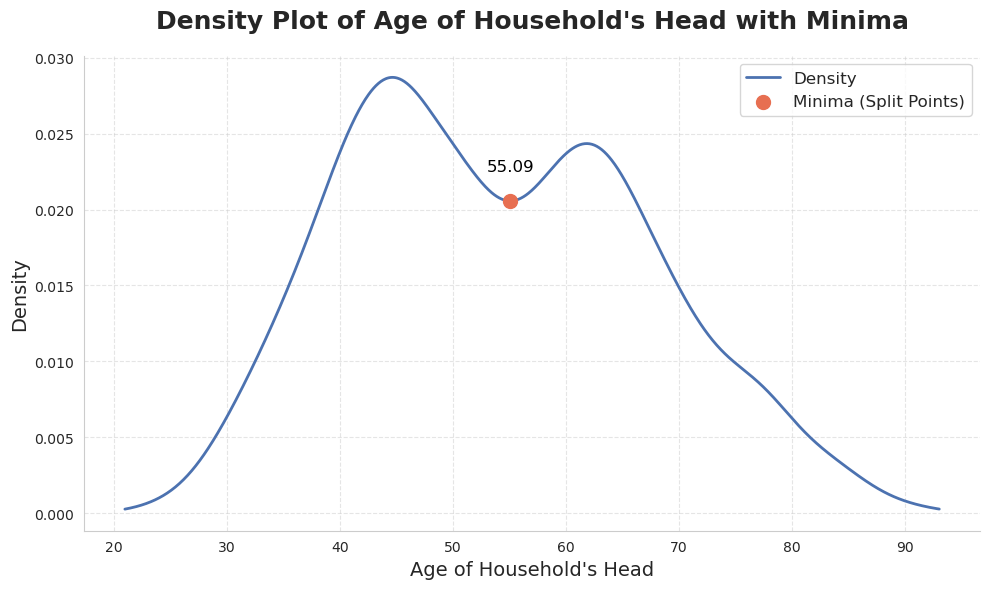

Split points (minima) in the distribution: [55.09009009]


In [43]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Extract the relevant 'ageh' column (Age of Household Head)
ageh_data = df['ageh'].dropna()

# Create a density estimate using Gaussian Kernel Density Estimation
kde = gaussian_kde(ageh_data)
age_range = np.linspace(ageh_data.min(), ageh_data.max(), 1000)
density_values = kde(age_range)

# Find the local minima (the split points)
minima_indices = find_peaks(-density_values)[0]
minima_ages = age_range[minima_indices]

# Plot the density and mark the minima
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot the density line with modern blue-gray color
plt.plot(age_range, density_values, color='#4c72b0', lw=2, label='Density')

# Highlight the minima with a sleek red marker
plt.scatter(minima_ages, density_values[minima_indices], color='#e76f51', zorder=5, s=100, label='Minima (Split Points)')

# Add plot annotations and labels
for i, age in enumerate(minima_ages):
    plt.text(age, density_values[minima_indices][i] + 0.002, f'{age:.2f}', fontsize=12, color='black', ha='center')

# Customize the plot for a modern, sleek look
plt.title("Density Plot of Age of Household's Head with Minima", fontsize=18, weight='bold', pad=20)
plt.xlabel("Age of Household's Head", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines for a cleaner look
sns.despine()

# Add a legend
plt.legend(fontsize=12)

# Improve spacing and layout
plt.tight_layout()

# Show the plot
plt.show()

# Print the minima for your reference
print(f"Split points (minima) in the distribution: {minima_ages}")

In [44]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Extract the relevant 'ageh' column (Age of Household Head)
ageh_data = df['ageh'].dropna()

# Create a density estimate using Gaussian Kernel Density Estimation
kde = gaussian_kde(ageh_data)
age_range = np.linspace(ageh_data.min(), ageh_data.max(), 1000)
density_values = kde(age_range)

# Find the local minima (the split points)
minima_indices = find_peaks(-density_values)[0]
minima_ages = age_range[minima_indices]

# Use the first (and only) split point for grouping
split_age = minima_ages[0]

# Create a new column to categorize ages into 'Young' and 'Old'
df['age_group'] = np.where(df['ageh'] <= split_age, 'Young', 'Old')

# Compute summary statistics for each group
summary_stats = df.groupby('age_group')['ageh'].describe()

# Rename both the index and the columns
summary_stats.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Std Dev',
    'min': 'Min',
    '25%': '25%',
    '50%': 'Median',
    '75%': '75%',
    'max': 'Max'
}, inplace=True)

summary_stats.index.name = 'Age Group'

# Display the updated summary statistics
summary_stats.style.set_caption("Summary Statistics for Age Groups").format("{:.2f}")

,Count,Mean,Std Dev,Min,25%,Median,75%,Max
Age Group,,,,,,,,
Old,2245.00,66.58,7.69,56.00,61.00,65.00,71.00,93.00
Young,2792.00,43.73,6.83,21.00,39.00,44.00,49.00,55.00


### Years of Education of Household Head

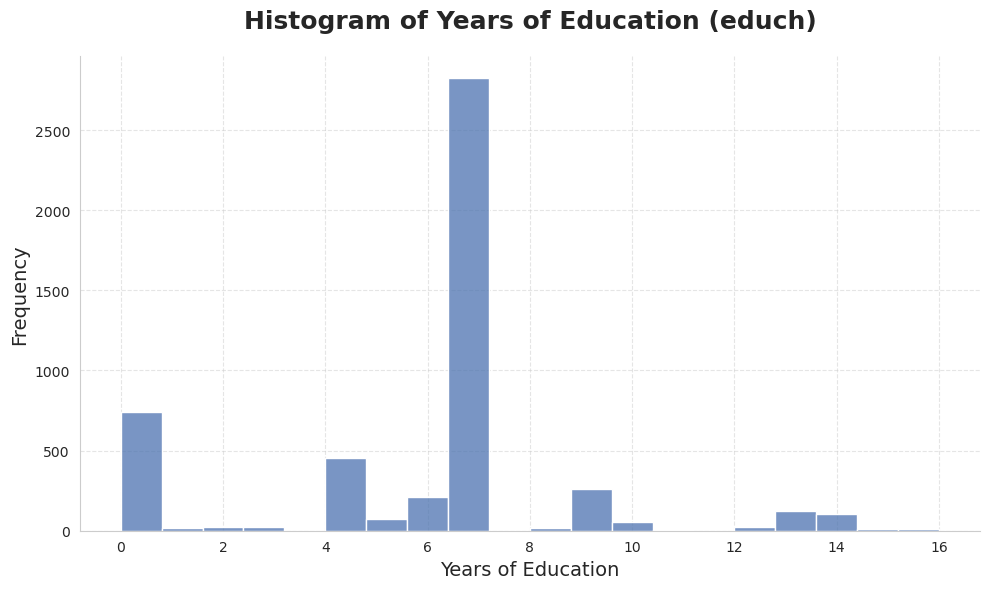

In [45]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Extract the relevant 'educh' column (Years of Education of Household Head)
educh_data = df['educh'].dropna()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram with modern color and white edges
sns.histplot(educh_data, bins=20, kde=False, color='#4c72b0', edgecolor='white')

# Customize the plot with a clean, modern look
plt.title("Histogram of Years of Education (educh)", fontsize=18, weight='bold', pad=20)
plt.xlabel("Years of Education", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

In [46]:
# Import necessary libraries
import numpy as np
import pandas as pd


# Define the buckets for education levels
bins = [0, 4, 8, 16]
labels = ['Low (0-4 years)', 'Medium (5-8 years)', 'High (9-16 years)']

# Create a new column 'education_bucket' for the defined buckets
df['education_bucket'] = pd.cut(df['educh'], bins=bins, labels=labels, include_lowest=True)

# Display summary statistics for each education bucket
summary_stats_buckets = df.groupby('education_bucket')['educh'].describe()

# Rename both the index and the columns
summary_stats_buckets.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Std Dev',
    'min': 'Min',
    '25%': '25%',
    '50%': 'Median',
    '75%': '75%',
    'max': 'Max'
}, inplace=True)

summary_stats_buckets.index.name = 'Education Group'

# Optionally, you can display the summary statistics in a visually styled table using pandas Styler
summary_stats_buckets.style.set_caption("Summary Statistics for Education Buckets").format("{:.2f}")

,Count,Mean,Std Dev,Min,25%,Median,75%,Max
Education Group,,,,,,,,
Low (0-4 years),1255.00,1.54,1.90,0.00,0.00,0.00,4.00,4.00
Medium (5-8 years),3124.00,6.89,0.40,5.00,7.00,7.00,7.00,8.00
High (9-16 years),588.00,11.16,2.22,9.00,9.00,10.00,13.00,16.00


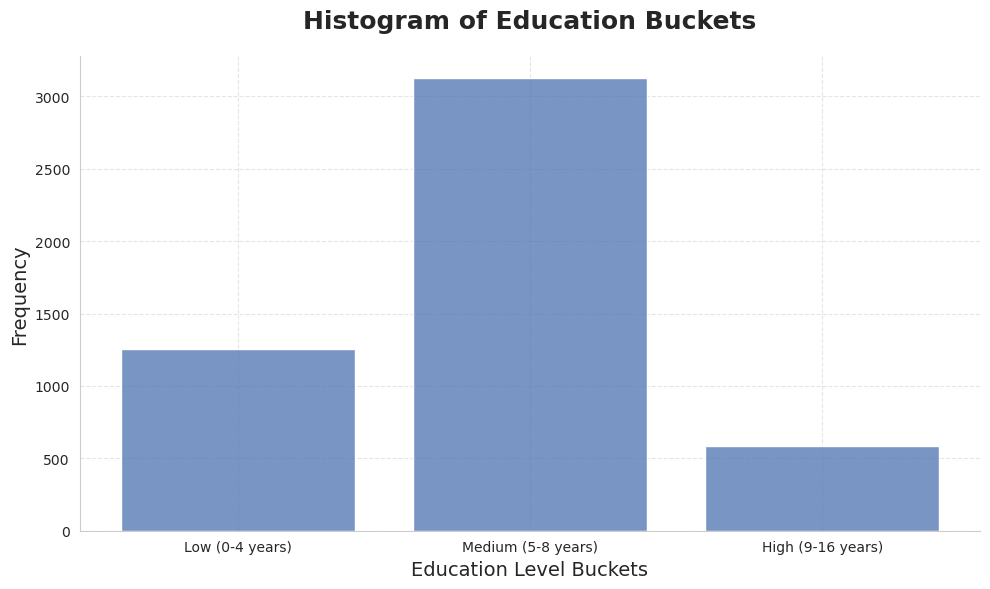

In [47]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a sleek seaborn style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histogram for the education buckets with modern style, narrower bars
sns.histplot(df['education_bucket'], color='#4c72b0', edgecolor='white', shrink=0.8)

# Customize the plot with a clean, modern look
plt.title("Histogram of Education Buckets", fontsize=18, weight='bold', pad=20)
plt.xlabel("Education Level Buckets", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

### Farmer Status

In [48]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Create a new column 'farmer_status' to distinguish farmers (1) and non-farmers (0)
df['farmer_status'] = np.where(df['farm'] == 1, 'Farmer', 'Non-Farmer')

# Display summary statistics for both farmers and non-farmers
summary_stats_farmers = df.groupby('farmer_status')['farm'].describe()

# Rename both the index and the columns
summary_stats_farmers.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Std Dev',
    'min': 'Min',
    '25%': '25%',
    '50%': 'Median',
    '75%': '75%',
    'max': 'Max'
}, inplace=True)

summary_stats_farmers.index.name = 'Farmer Status'

# Optionally, you can display the summary statistics in a visually styled table using pandas Styler
summary_stats_farmers.style.set_caption("Summary Statistics for Farmers and Non-Farmers").format("{:.2f}")

,Count,Mean,Std Dev,Min,25%,Median,75%,Max
Farmer Status,,,,,,,,
Farmer,3248.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
Non-Farmer,1827.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


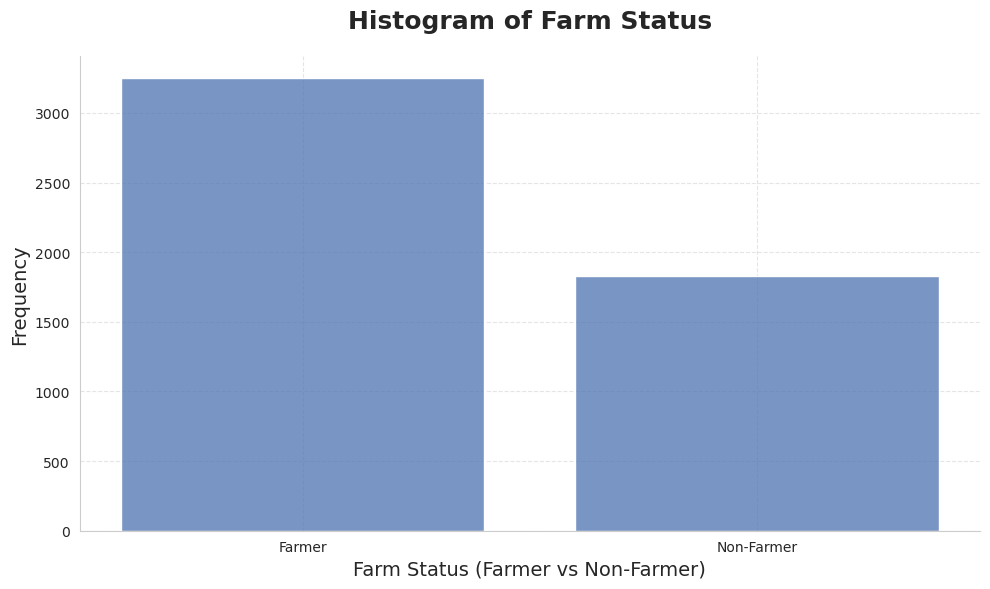

In [49]:
# It seems the 'farmer_status' column wasn't created successfully, let's create it again and then plot

# Create a new column 'farmer_status' to distinguish farmers (1) and non-farmers (0)
df['farmer_status'] = np.where(df['farm'] == 1, 'Farmer', 'Non-Farmer')

# Create the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plot histogram for the farm status with modern style, narrower bars
sns.histplot(df['farmer_status'], color='#4c72b0', edgecolor='white', shrink=0.8)

# Customize the plot with a clean, modern look
plt.title("Histogram of Farm Status", fontsize=18, weight='bold', pad=20)
plt.xlabel("Farm Status (Farmer vs Non-Farmer)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Remove top and right spines for a sleek look
sns.despine()

# Subtle gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Improve spacing
plt.tight_layout()

# Display the plot
plt.show()

## IV & OLS Regression

### First Stage Regression (IV)

In [50]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Convert 'year' to numeric type to avoid the time index error
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['caseid'] = df['caseid'].astype('category')

# Set index to 'caseid' and 'year', and make sure the index levels are named
df = df.set_index(['caseid', 'year'])
df.index.names = ['caseid', 'year']

# Reset the index to treat 'caseid' and 'year' as regular columns for merging the year dummies
df_reset = df.reset_index()

# Manually create year dummies using pandas, and drop the first category (year 1)
year_dummies = pd.get_dummies(df_reset['year'], prefix='year', drop_first=True)

# Add the year dummies to the dataframe
df_reset = df_reset.join(year_dummies)

# Set the index back to 'caseid' and 'year' after adding the dummies
df_reset = df_reset.set_index(['caseid', 'year'])

# Define the formula for the first stage regression, now using the manually created year dummies
formula = 'vfst ~ invHHtvf1 + invHHtvf2 + madult + fadult + kids + maleh + farm + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the fixed effects model
model = PanelOLS.from_formula(formula, df_reset)

# Fit the model with robust standard errors and clustering by 'villageyear'
result = model.fit(cov_type='clustered', clusters=df_reset['villageyear'])

# Store the predicted values from the first stage
df_reset['vfst_hat'] = result.fitted_values

# Print the summary of the results
print(result.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   vfst   R-squared:                        0.4662
Estimator:                   PanelOLS   R-squared (Between):             -4.1024
No. Observations:                4967   R-squared (Within):               0.4662
Date:                Sun, Oct 20 2024   R-squared (Overall):             -0.6669
Time:                        22:37:32   Log-likelihood                   -3322.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      230.88
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(16,4229)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             66.343
                            

### General Second Stage Regression

In [51]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Extract 'year' from the index and add it back as a column
df_reset['year'] = df_reset.index.get_level_values('year')

# Manually create year dummies using pandas, and drop the first category (year 1)
year_dummies = pd.get_dummies(df_reset['year'], prefix='year', drop_first=True)

# Add the year dummies to the dataframe
df_reset = df_reset.join(year_dummies, rsuffix='_new')

# Define the formula for the second stage regression, using 'vfst_hat' and year dummies
# We also include explicit entity (caseid) fixed effects by adding 'EntityEffects'
formula = 'newst ~ vfst_hat + madult + fadult + kids + maleh + farm + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2 = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0220
Estimator:                   PanelOLS   R-squared (Between):              0.0896
No. Observations:                4967   R-squared (Within):               0.0220
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.0604
Time:                        22:37:36   Log-likelihood                -5.954e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.3439
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(15,4230)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             6.0753
                            

### General OLS

In [52]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Extract 'year' from the index and add it back as a column
df_reset['year'] = df_reset.index.get_level_values('year')

# Manually create year dummies using pandas, and drop the first category (year 1)
year_dummies = pd.get_dummies(df_reset['year'], prefix='year', drop_first=True)

# Add the year dummies to the dataframe
df_reset = df_reset.join(year_dummies, rsuffix='_new')

# Define the formula for the second stage regression, using 'vfst_hat' and year dummies
# We also include explicit entity (caseid) fixed effects by adding 'EntityEffects'
formula = 'newst ~ vfst + madult + fadult + kids + maleh + farm + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2 = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0435
Estimator:                   PanelOLS   R-squared (Between):              0.2347
No. Observations:                4967   R-squared (Within):               0.0435
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.1473
Time:                        22:37:48   Log-likelihood                -5.949e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.814
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(15,4230)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             14.065
                            

### Age Regression

In [53]:
# Ensure 'age_group' is a categorical variable
df_reset['age_group'] = df_reset['age_group'].astype('category')

# Create interaction terms for 'vfst_hat' with 'age_group' (Young and Old)
df_reset['vfst_hat_Young'] = df_reset['vfst_hat'] * (df_reset['age_group'] == 'Young').astype(int)
df_reset['vfst_hat_Old'] = df_reset['vfst_hat'] * (df_reset['age_group'] == 'Old').astype(int)

# Define the formula fbbor the second stage regression, excluding ageh and age2h
formula = 'newst ~ vfst_hat_Young + vfst_hat_Old + madult + fadult + kids + maleh + farm + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_age = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_age.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0224
Estimator:                   PanelOLS   R-squared (Between):              0.1916
No. Observations:                4967   R-squared (Within):               0.0224
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.1146
Time:                        22:37:57   Log-likelihood                -5.954e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.9152
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(14,4231)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             5.7244
                            

### Age OLS

In [55]:
# Ensure 'age_group' is a categorical variable
df_reset['age_group'] = df_reset['age_group'].astype('category')

# Create interaction terms for 'vfst_hat' with 'age_group' (Young and Old)
df_reset['vfst_Young'] = df_reset['vfst'] * (df_reset['age_group'] == 'Young').astype(int)
df_reset['vfst_Old'] = df_reset['vfst'] * (df_reset['age_group'] == 'Old').astype(int)

# Define the formula fbbor the second stage regression, excluding ageh and age2h
formula = 'newst ~ vfst_Young + vfst_Old + madult + fadult + kids + maleh + farm + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_age = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_age.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0446
Estimator:                   PanelOLS   R-squared (Between):              0.2922
No. Observations:                4967   R-squared (Within):               0.0446
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.1778
Time:                        22:38:13   Log-likelihood                -5.948e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      14.093
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(14,4231)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             17.814
                            

### Education Regression

In [18]:
# Ensure 'education_bucket' is a categorical variable
df_reset['education_bucket'] = df['education_bucket'].astype('category')

# Create interaction terms for 'vfst_hat' with each education bucket
df_reset['vfst_hat_Low'] = df_reset['vfst_hat'] * (df_reset['education_bucket'] == 'Low (0-4 years)').astype(int)
df_reset['vfst_hat_Medium'] = df_reset['vfst_hat'] * (df_reset['education_bucket'] == 'Medium (5-8 years)').astype(int)
df_reset['vfst_hat_High'] = df_reset['vfst_hat'] * (df_reset['education_bucket'] == 'High (9-16 years)').astype(int)

# Define the formula for the second stage regression, using interaction terms for education buckets
formula = 'newst ~ vfst_hat_Low + vfst_hat_Medium + vfst_hat_High + madult + fadult + kids + maleh + farm + ageh + age2h + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_education = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_education.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0226
Estimator:                   PanelOLS   R-squared (Between):              0.0425
No. Observations:                4967   R-squared (Within):               0.0226
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.0371
Time:                        22:31:39   Log-likelihood                -5.954e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.1120
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(16,4229)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             6.5970
                            

### Education OLS

In [57]:
# Ensure 'education_bucket' is a categorical variable
df_reset['education_bucket'] = df['education_bucket'].astype('category')

# Create interaction terms for 'vfst_hat' with each education bucket
df_reset['vfst_Low'] = df_reset['vfst'] * (df_reset['education_bucket'] == 'Low (0-4 years)').astype(int)
df_reset['vfst_Medium'] = df_reset['vfst'] * (df_reset['education_bucket'] == 'Medium (5-8 years)').astype(int)
df_reset['vfst_High'] = df_reset['vfst'] * (df_reset['education_bucket'] == 'High (9-16 years)').astype(int)

# Define the formula for the second stage regression, using interaction terms for education buckets
formula = 'newst ~ vfst_Low + vfst_Medium + vfst_High + madult + fadult + kids + maleh + farm + ageh + age2h + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_education = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_education.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0428
Estimator:                   PanelOLS   R-squared (Between):              0.2104
No. Observations:                5037   R-squared (Within):               0.0428
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.1324
Time:                        22:39:43   Log-likelihood                -6.032e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.993
Entities:                         725   P-value                           0.0000
Avg Obs:                       6.9476   Distribution:                 F(16,4296)
Min Obs:                       6.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             22.773
                            

### Occupation Regression

In [19]:
# Ensure 'farmer_status' is a categorical variable
df_reset['farmer_status'] = df['farmer_status'].astype('category')

# Create interaction terms for 'vfst_hat' with 'farmer_status'
df_reset['vfst_hat_Farmer'] = df_reset['vfst_hat'] * (df_reset['farmer_status'] == 'Farmer').astype(int)
df_reset['vfst_hat_NonFarmer'] = df_reset['vfst_hat'] * (df_reset['farmer_status'] == 'Non-Farmer').astype(int)

# Define the formula for the second stage regression, using interaction terms for farmer status
formula = 'newst ~ vfst_hat_Farmer + vfst_hat_NonFarmer + madult + fadult + kids + maleh + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_occupation = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_occupation.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0220
Estimator:                   PanelOLS   R-squared (Between):              0.0830
No. Observations:                4967   R-squared (Within):               0.0220
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.0568
Time:                        22:31:39   Log-likelihood                -5.954e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.3351
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(15,4230)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             6.0219
                            

### Occupation OLS

In [59]:
# Ensure 'farmer_status' is a categorical variable
df_reset['farmer_status'] = df['farmer_status'].astype('category')

# Create interaction terms for 'vfst_hat' with 'farmer_status'
df_reset['vfst_Farmer'] = df_reset['vfst'] * (df_reset['farmer_status'] == 'Farmer').astype(int)
df_reset['vfst_NonFarmer'] = df_reset['vfst'] * (df_reset['farmer_status'] == 'Non-Farmer').astype(int)

# Define the formula for the second stage regression, using interaction terms for farmer status
formula = 'newst ~ vfst_Farmer + vfst_NonFarmer + madult + fadult + kids + maleh + ageh + age2h + educh + ' + ' + '.join(year_dummies.columns) + ' + EntityEffects'

# Fit the second stage model with clustering by 'villageyear'
model2 = PanelOLS.from_formula(formula, df_reset, drop_absorbed=True)

# Fit the model with robust standard errors and clustering by 'villageyear'
result2_occupation = model2.fit(cov_type='clustered', clusters=df_reset['villageyear'], auto_df=True)

# Print the summary of the results
print(result2_occupation.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  newst   R-squared:                        0.0428
Estimator:                   PanelOLS   R-squared (Between):              0.2006
No. Observations:                4967   R-squared (Within):               0.0428
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.1288
Time:                        22:41:32   Log-likelihood                -5.949e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.602
Entities:                         722   P-value                           0.0000
Avg Obs:                       6.8795   Distribution:                 F(15,4230)
Min Obs:                       1.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             16.887
                            